In [1]:
import tensorflow as tf
from hyperopt import hp
import pickle
from collections import defaultdict
import pandas as pd

2024-05-21 23:23:34.208034: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 23:23:34.352299: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 23:23:34.352401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 23:23:34.367856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 23:23:34.429872: I tensorflow/core/platform/cpu_feature_guar

In [2]:
with open("./classiccontrol_trials.p", "rb") as f:
  trials = pickle.load(f)
print(trials)

In [3]:
print(trials.trials)
print(trials.results)
print(trials.losses())
print(trials.statuses())

[{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': -9.4, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'activation': [0], 'actor_buffer_size': [0], 'actors_initial_sigma': [0], 'actors_sigma_alpha': [0], 'adam_epsilon': [0], 'advantage_hidden_layers': [0], 'atom_size': [0], 'clipnorm': [0], 'dense_layers': [0], 'discount_factor': [0], 'kernel_initializer': [0], 'learner_noisy_sigma': [0], 'learning_rate': [0], 'loss_function': [0], 'min_replay_buffer_size': [0], 'minibatch_size': [0], 'n_step': [0], 'num_actors': [0], 'per_alpha': [0], 'per_beta': [0], 'per_epsilon': [0], 'poll_params_interval': [0], 'push_params_interval': [0], 'replay_buffer_size': [0], 'samples_queue_size': [0], 'transfer_interval': [0], 'updates_queue_size': [0], 'value_hidden_layers': [0], 'width': [0]}, 'vals': {'activation': [0], 'actor_buffer_size': [7], 'actors_initial_sigma': [8], 'actors_sigma_alpha': [11], 'adam_epsilon': [5], 'advantage

In [4]:
def create_search_space():
    search_space = {
        "activation": hp.choice("activation", ["relu"]),
        "kernel_initializer": hp.choice(
            "kernel_initializer",
            [
                "he_uniform",
                "he_normal",
                "glorot_uniform",
                "glorot_normal",
                # "lecun_uniform",
                # "lecun_normal",
                "orthogonal",
                "variance_baseline",
                "variance_0.1",
                "variance_0.3",
                "variance_0.8",
                "variance_3",
                "variance_5",
                "variance_10",
            ],
        ),
        "learning_rate": hp.choice(
            "learning_rate", [0.1, 0.01, 0.001, 0.0001, 0.00001]
        ),  #
        "adam_epsilon": hp.choice(
            "adam_epsilon",
            [0.3125, 0.03125, 0.003125, 0.0003125, 0.00003125, 0.000003125],
        ),
        "clipnorm": hp.choice(
            "clipnorm", [None, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
        ),
        # NORMALIZATION?
        "transfer_interval": hp.choice(
            "transfer_interval", [10, 25, 50, 100, 200, 400, 800, 1600, 2000]
        ),
        "minibatch_size": hp.choice("minibatch_size", [2**i for i in range(3, 8)]),
        "replay_buffer_size": hp.choice(
            "replay_buffer_size",
            [2000, 3000, 5000, 7500, 10000, 15000, 20000, 25000, 50000, 100000],
        ),
        "actor_buffer_size": hp.choice(
            "actor_buffer_size", [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
        ),
        "min_replay_buffer_size": hp.choice(
            "min_replay_buffer_size",
            [125, 250, 375, 500, 625, 750, 875, 1000, 1500, 2000],
        ),
        "n_step": hp.choice("n_step", [1, 2, 3, 4, 5, 8, 10]),
        "discount_factor": hp.choice("discount_factor", [0.9, 0.99, 0.995, 0.999]),
        "atom_size": hp.choice("atom_size", [41, 51, 61, 71, 81]),  #
        "width": hp.choice("width", [32, 64, 128, 256, 512, 1024]),
        "dense_layers": hp.choice("dense_layers", [0, 1, 2, 3, 4]),
        # REWARD CLIPPING
        "loss_function": hp.choice(
            "loss_function",
            [tf.keras.losses.CategoricalCrossentropy(), tf.keras.losses.KLDivergence()],
        ),
        "advantage_hidden_layers": hp.choice(
            "advantage_hidden_layers", [0, 1, 2, 3, 4]
        ),  #
        "value_hidden_layers": hp.choice("value_hidden_layers", [0, 1, 2, 3, 4]),  #
        "per_epsilon": hp.choice(
            "per_epsilon", [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
        ),
        "per_alpha": hp.choice("per_alpha", [0.05 * i for i in range(0, 21)]),
        "per_beta": hp.choice("per_beta", [0.05 * i for i in range(1, 21)]),
        "push_params_interval": hp.choice(
            "push_params_interval", [2, 3, 4, 5, 8, 10, 12]
        ),
        "updates_queue_size": hp.choice(
            "updates_queue_size", [1, 2, 3, 4, 5, 8, 10, 12]
        ),
        "samples_queue_size": hp.choice(
            "samples_queue_size", [1, 2, 3, 4, 5, 8, 10, 12]
        ),
        # "remove_old_experiences_interval": hp.choice(
        #     "remove_old_experiences_interval", [1000, 2000, 3000, 4000, 5000, 8000, 10000]
        # ),
        "poll_params_interval": hp.choice("poll_params_interval", [50, 100, 200, 300]),
        "actors_initial_sigma": hp.choice(
            "actors_initial_sigma", [0.1 * i for i in range(1, 10)]
        ),
        "actors_sigma_alpha": hp.choice(
            "actors_sigma_alpha", [i for i in range(1, 20)]
        ),
        "learner_noisy_sigma": hp.choice(
            "learner_noisy_sigma", [0.1 * i for i in range(1, 10)]
        ),
        "num_actors": hp.choice("num_actors", [i for i in range(1, 16 + 1)]),
        # 'per_beta_increase': hp.uniform('per_beta_increase', 0, 0.015),
        # 'search_max_depth': 5,
        # 'search_max_time': 10,
    }
    initial_best_config = []

    return search_space, initial_best_config

ss, ibc = create_search_space()

ss_mod = defaultdict(list)
for k in ss:
    for apply in ss[k].inputs():
        if hasattr(apply, "obj"):
            ss_mod[k].append(apply.obj)

for k,v in ss_mod.items():
    print(f"{k:25} ({len(v):-2}): {v}")

activation                ( 1): ['relu']
kernel_initializer        (12): ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal', 'orthogonal', 'variance_baseline', 'variance_0.1', 'variance_0.3', 'variance_0.8', 'variance_3', 'variance_5', 'variance_10']
learning_rate             ( 5): [0.1, 0.01, 0.001, 0.0001, 1e-05]
adam_epsilon              ( 6): [0.3125, 0.03125, 0.003125, 0.0003125, 3.125e-05, 3.125e-06]
clipnorm                  (10): [None, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
transfer_interval         ( 9): [10, 25, 50, 100, 200, 400, 800, 1600, 2000]
minibatch_size            ( 5): [8, 16, 32, 64, 128]
replay_buffer_size        (10): [2000, 3000, 5000, 7500, 10000, 15000, 20000, 25000, 50000, 100000]
actor_buffer_size         (10): [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
min_replay_buffer_size    (10): [125, 250, 375, 500, 625, 750, 875, 1000, 1500, 2000]
n_step                    ( 7): [1, 2, 3, 4, 5, 8, 10]
discount_factor           ( 4): [0.9, 0.99, 0

In [5]:
values_dict = defaultdict(list)
scores = list()

i = 0
for trial in trials.trials:
  vals_idxs_dict = trial["misc"]["vals"]
  for k, v in vals_idxs_dict.items():
    idx = v[0]
    ss_val = ss_mod[k][v[0]]
    values_dict[k].append(ss_val)
  score = -trial["result"]["loss"]
  scores.append(score)

for k, v in values_dict.items():
  print(f"{k:25}: {v}")

df = pd.DataFrame(values_dict)
x_cols = df.columns
df["scores"] = scores

activation               : ['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu']
actor_buffer_size        : [800, 200, 300, 100, 1000, 800, 100, 800, 500, 500, 500, 400, 400, 400, 800, 400, 500, 30

In [6]:
def generate_graphs(df: pd.DataFrame, x_cols: list[str], score_col: str):
  for col in x_cols:
    if col == "loss_function":
      continue
    plt = df.plot(x=col, y="scores", kind="scatter", ylim=(0, 500))
    grouped = df.groupby(col)['scores'] 
    medians = grouped.median()
    means = grouped.mean()
    stddev = grouped.std() 


    if not (col == "kernel_initializer" or col == "activation"):
      plt.fill_between(medians.index, medians.values-stddev, medians.values+stddev, color="#00F0F0")
      plt.plot(means.index, means.values, color="#00FFFF")
    else:
      plt.scatter(means.index, means.values, c="#00FFFF")
    # plt.add_line



/home/ezrahuang/miniconda3/envs/ml/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


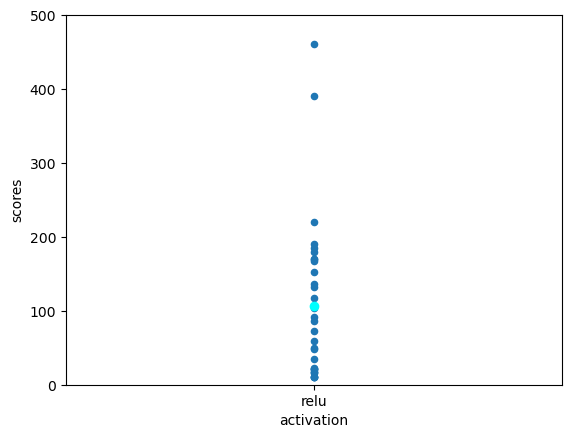

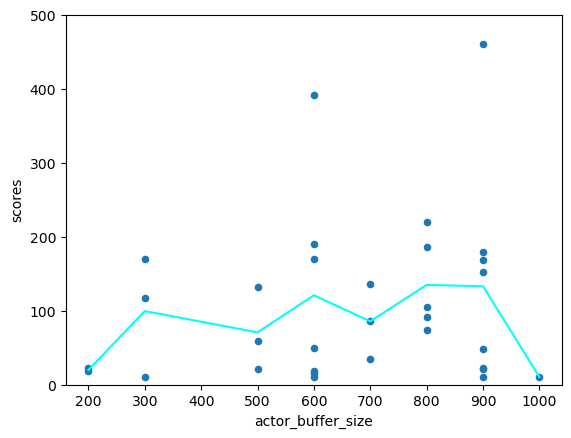

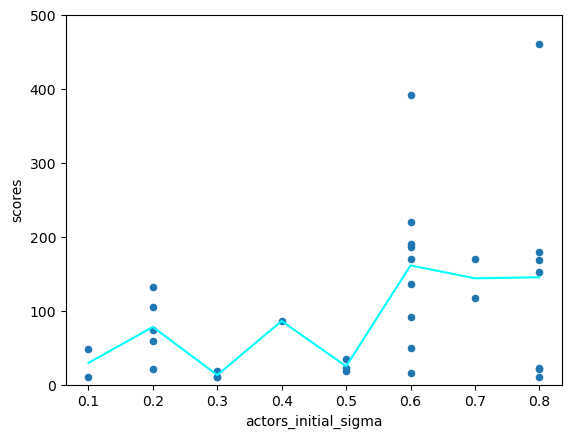

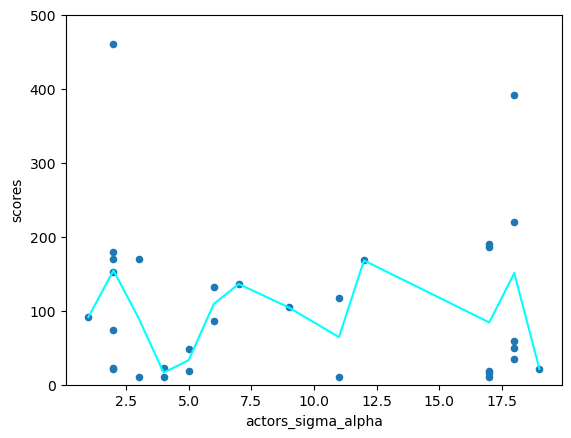

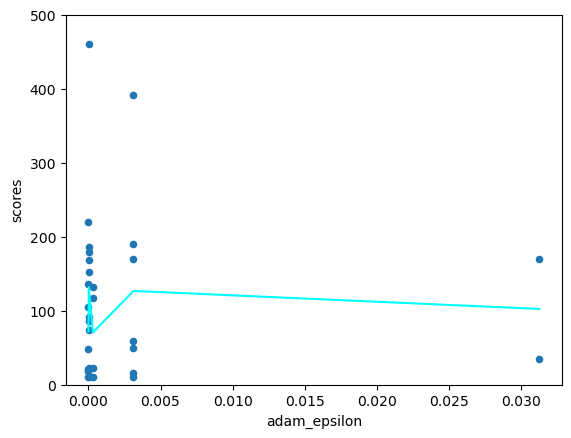

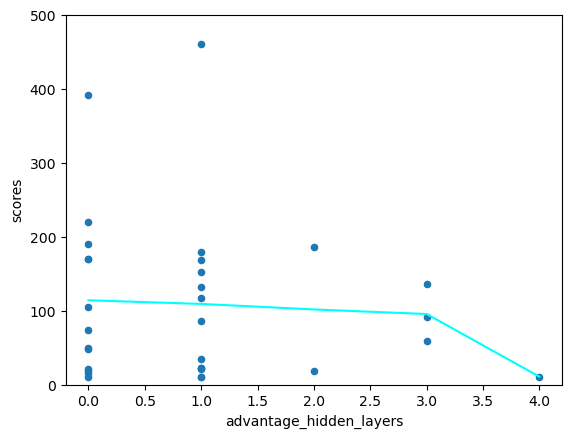

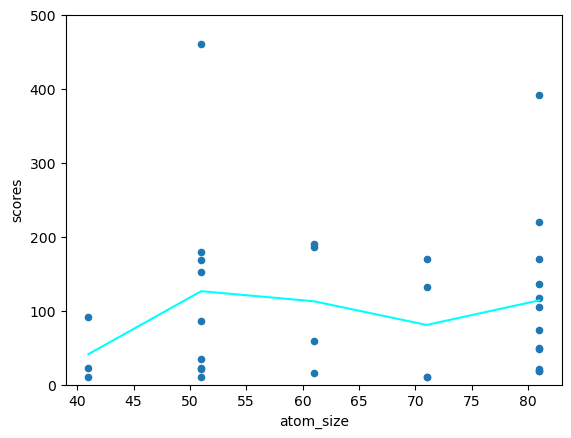

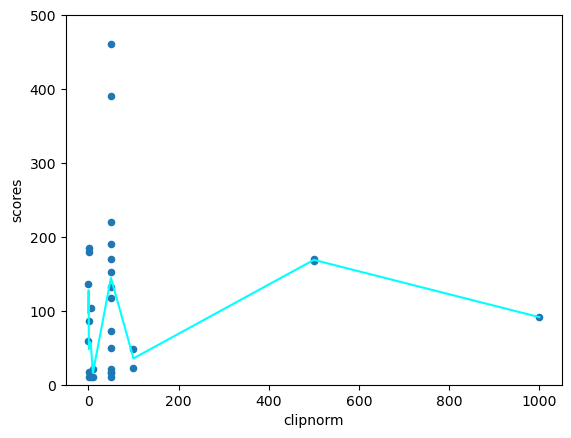

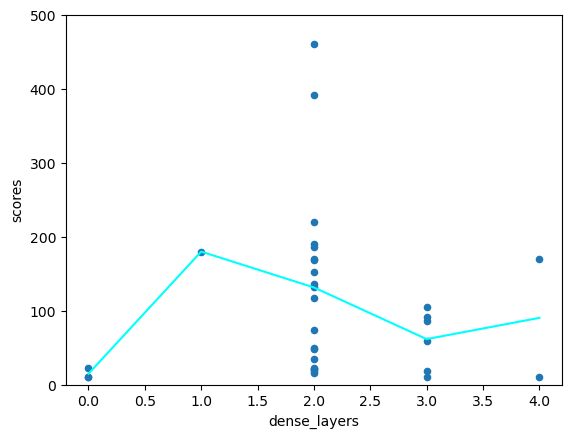

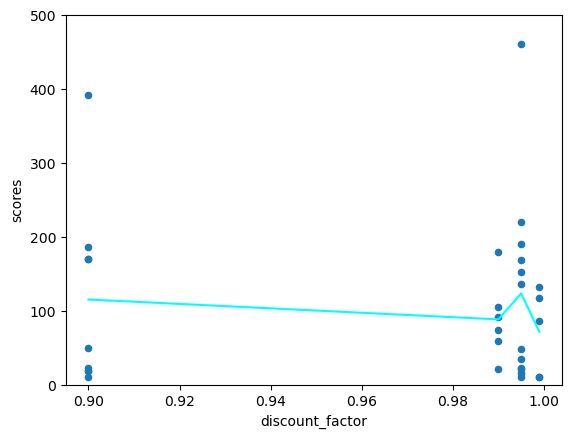

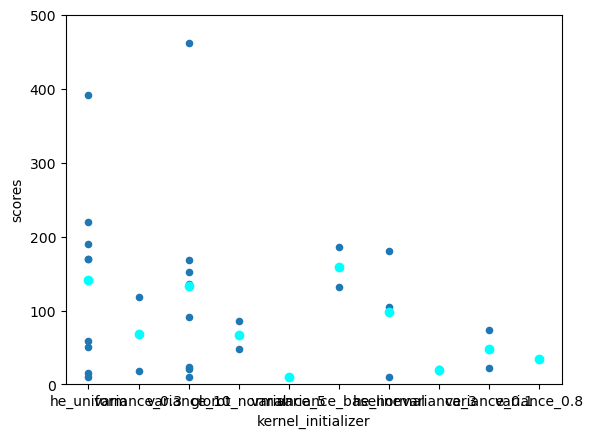

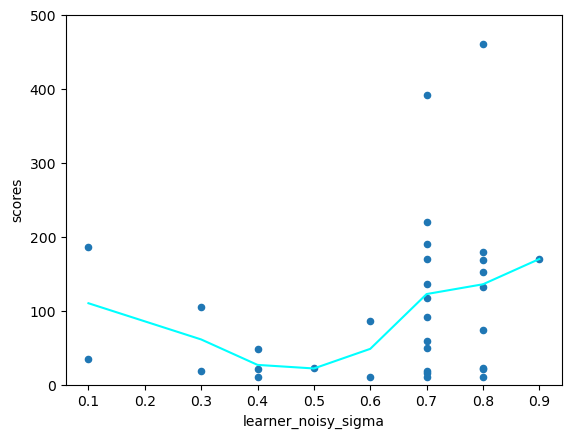

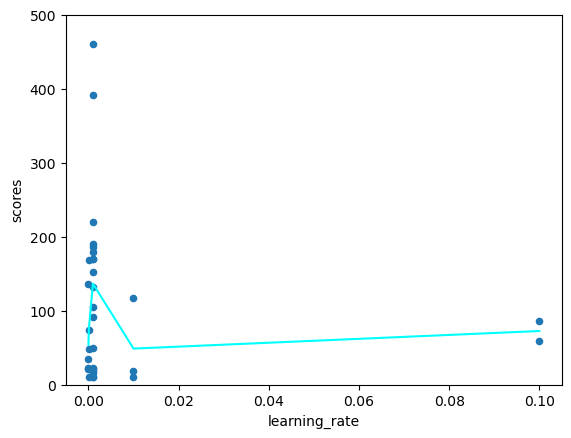

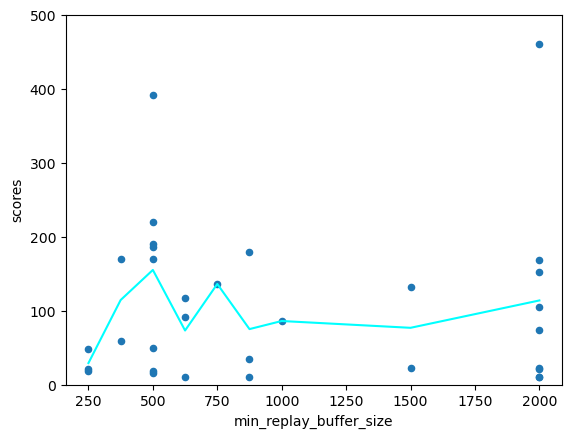

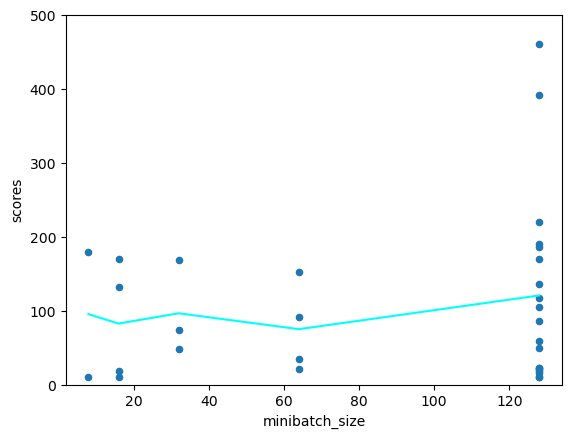

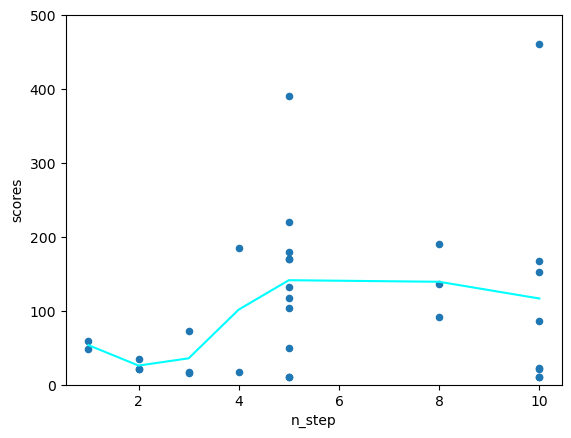

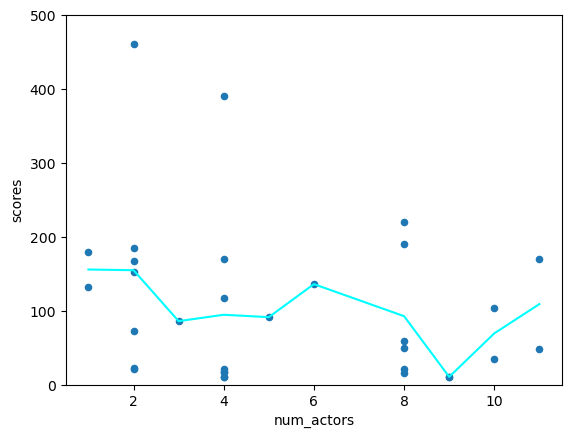

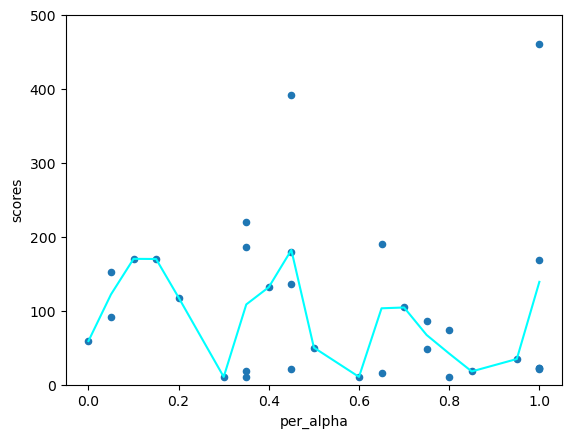

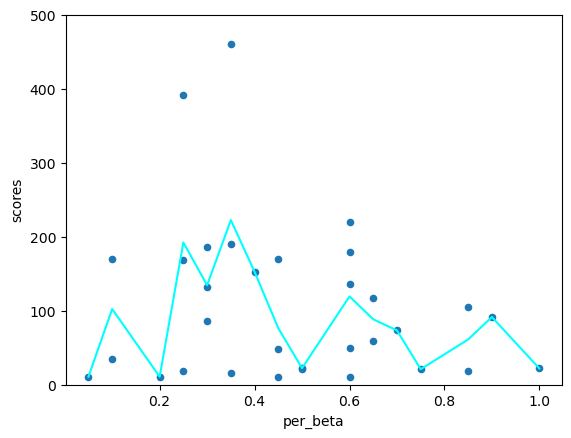

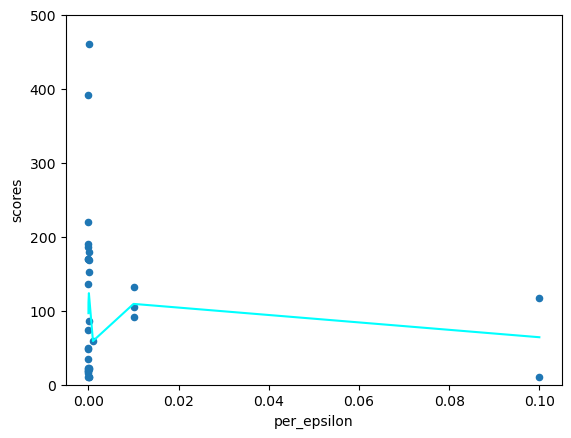

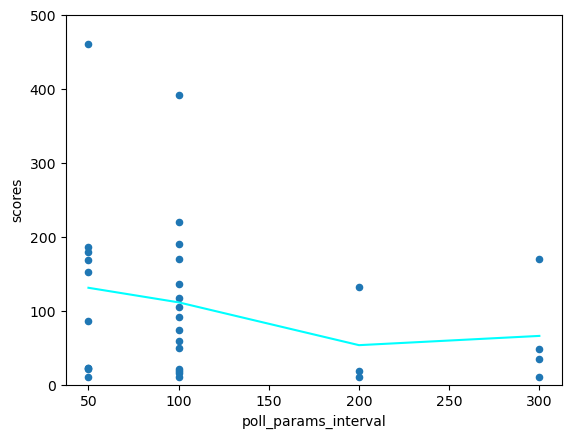

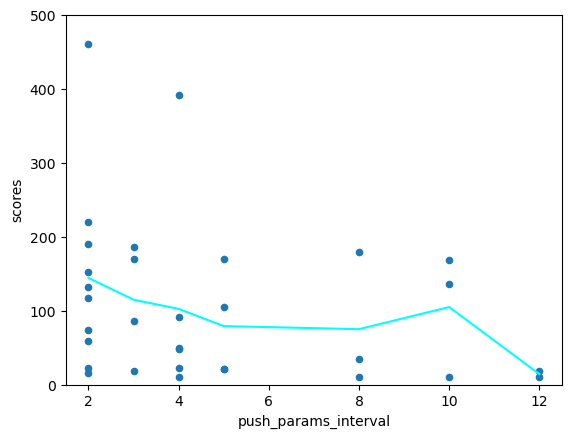

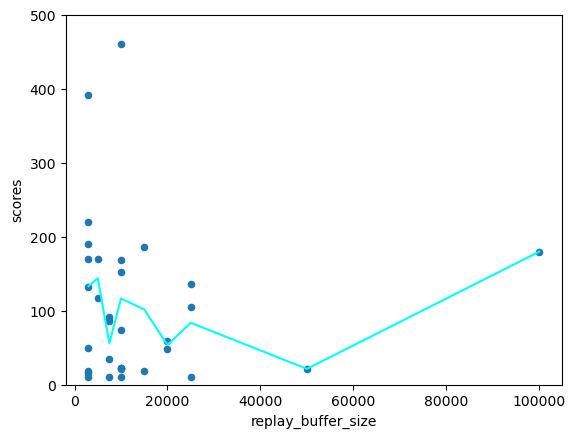

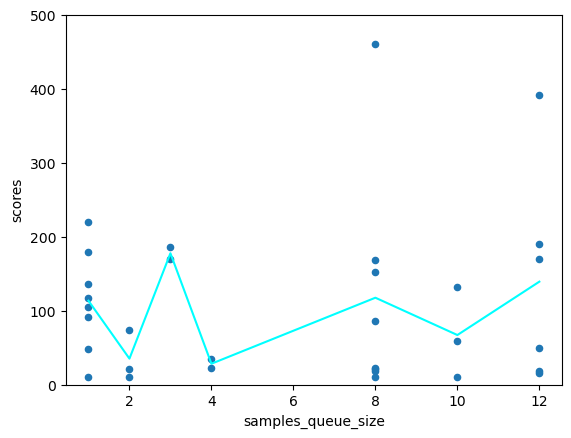

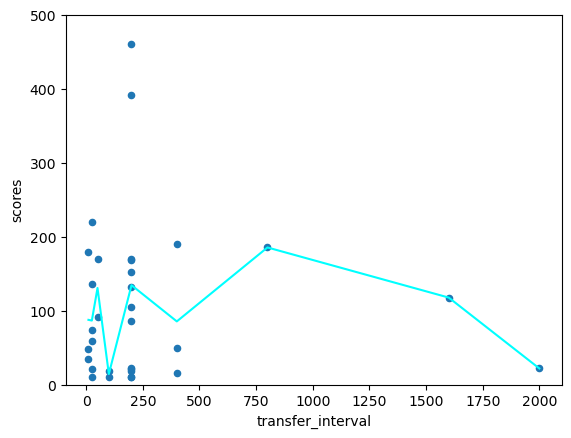

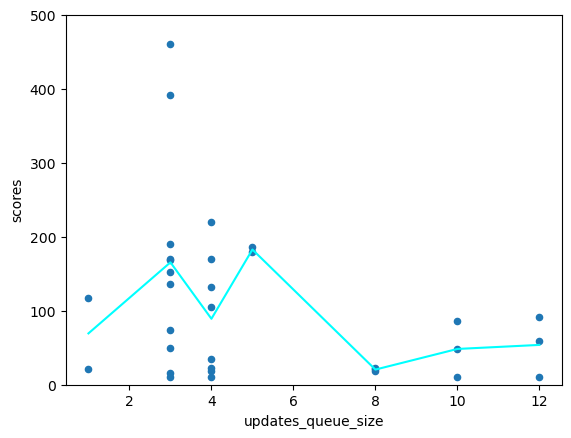

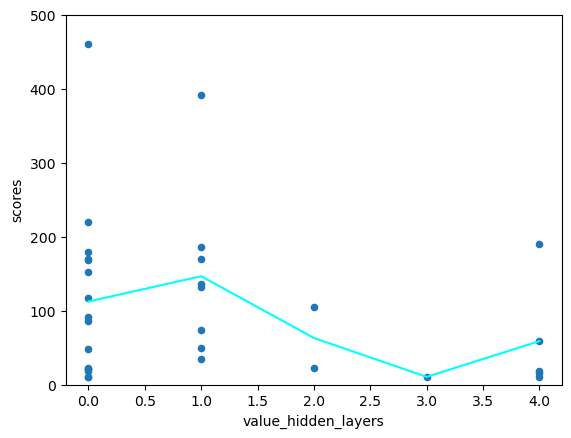

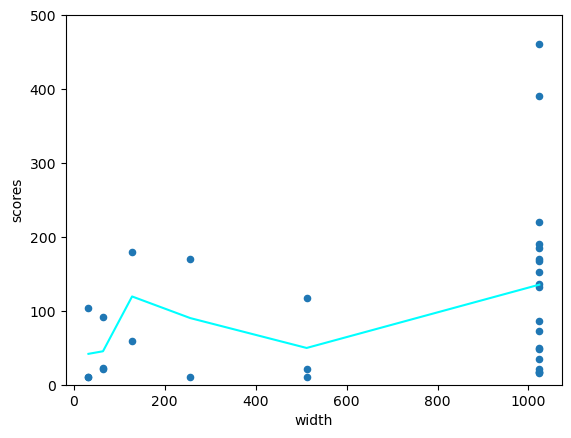

In [7]:
filtered = df[df["scores"] > 10]
generate_graphs(filtered, x_cols, "scores")

/home/ezrahuang/miniconda3/envs/ml/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


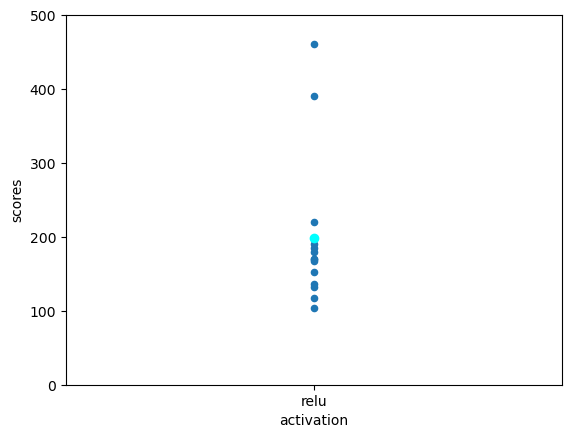

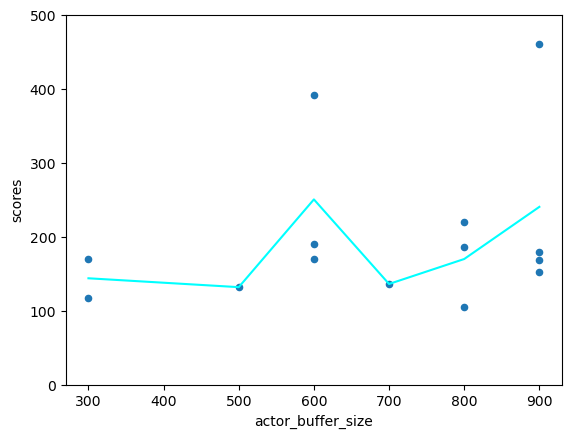

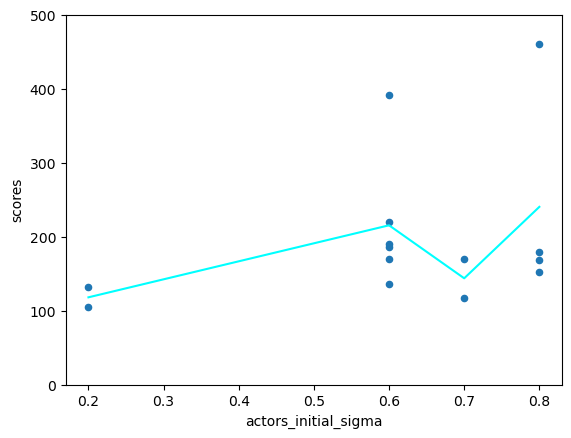

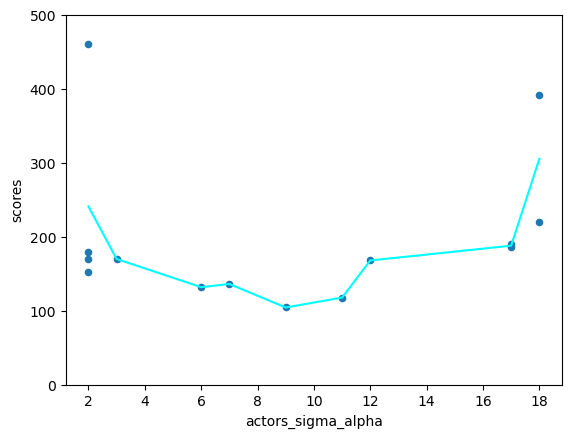

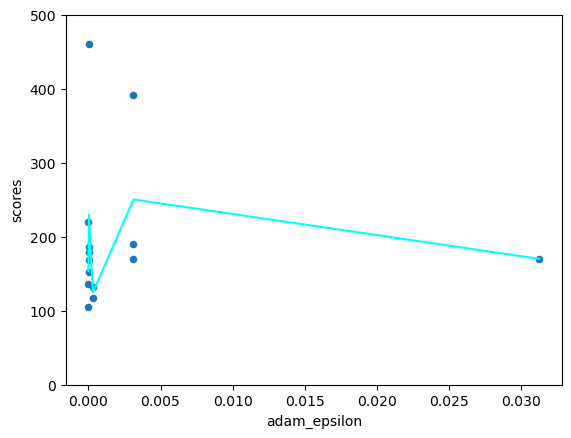

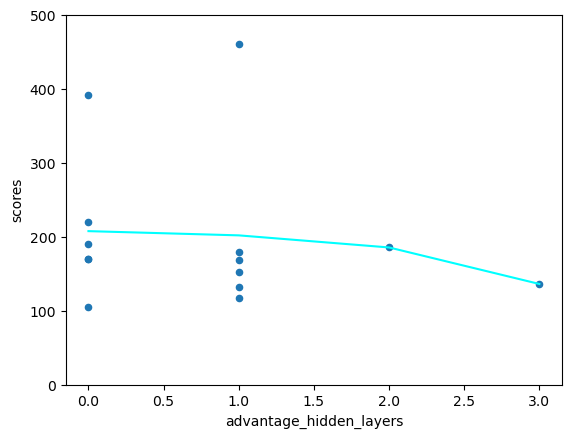

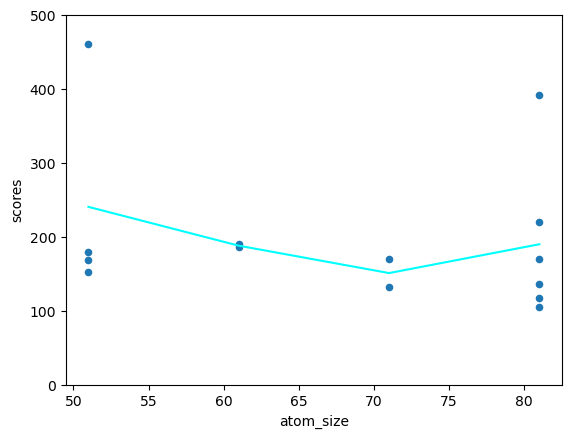

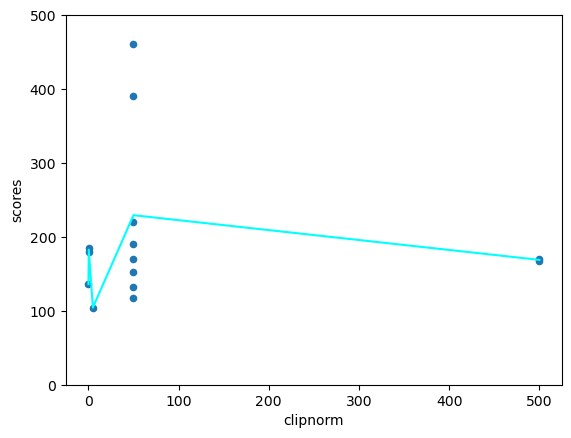

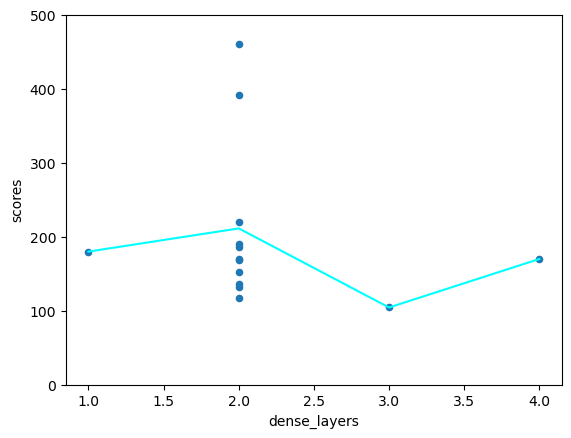

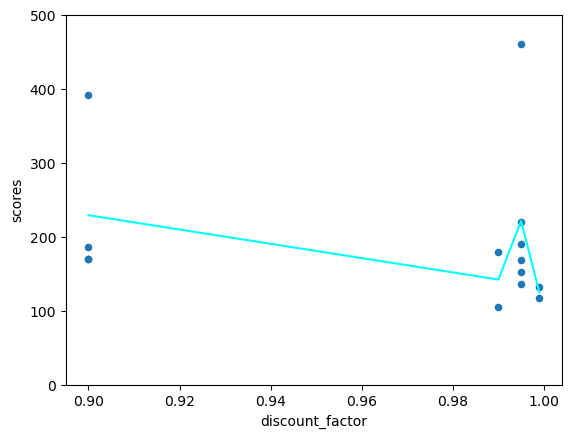

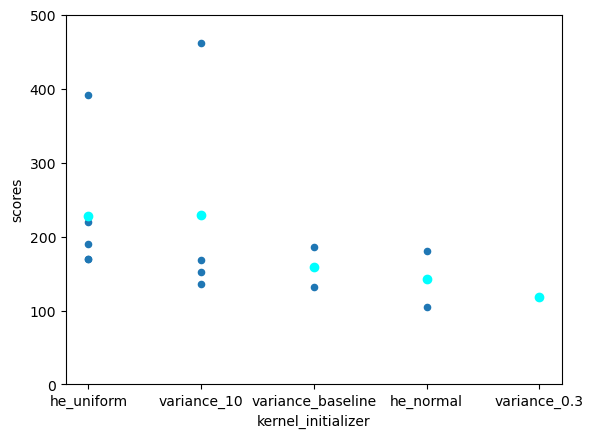

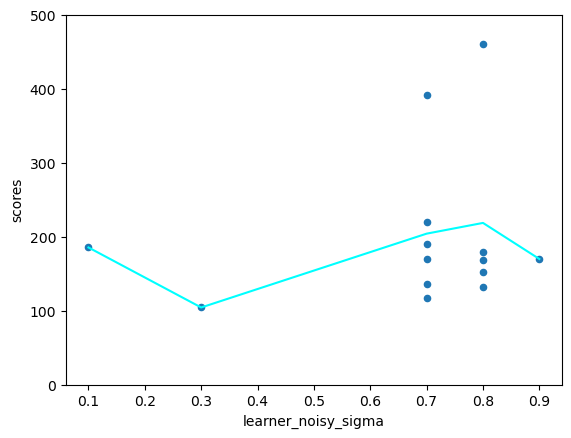

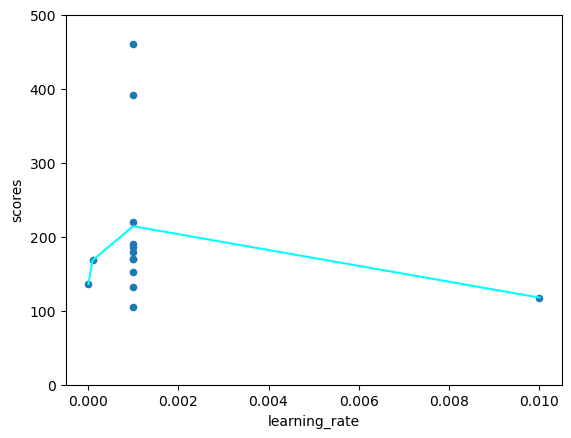

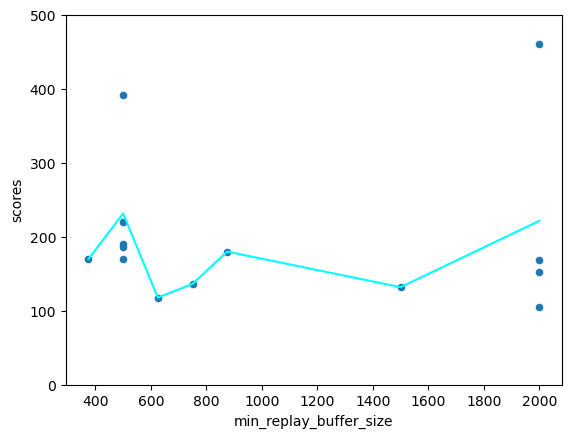

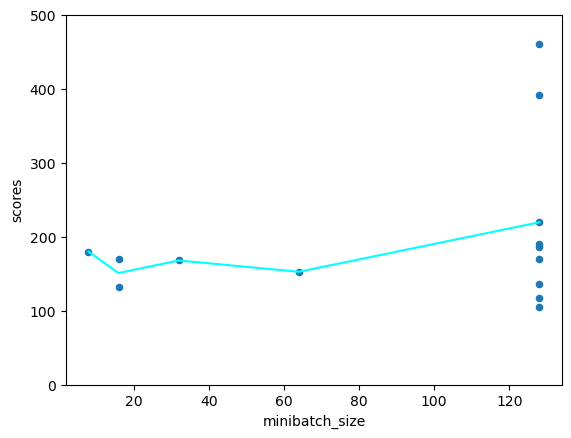

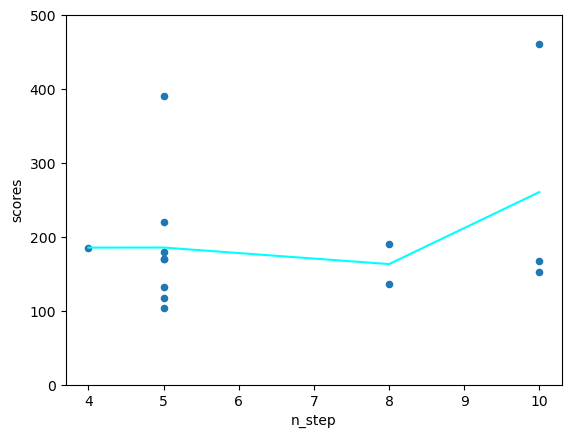

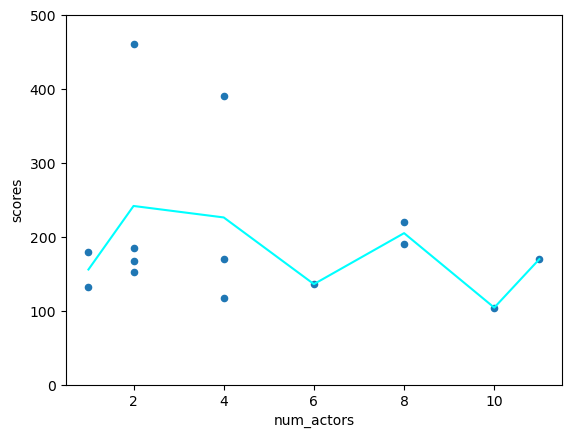

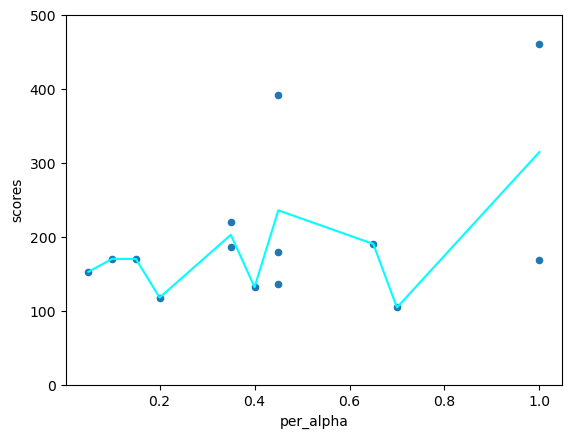

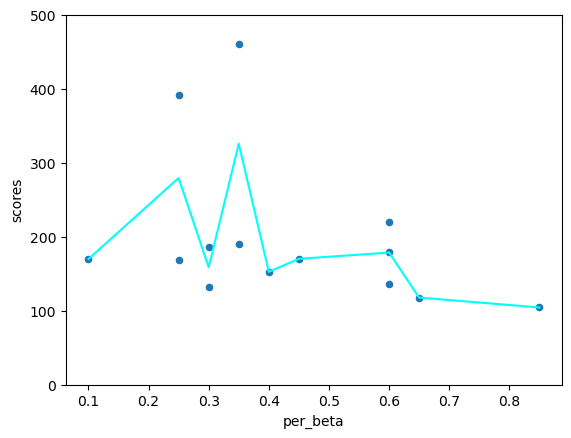

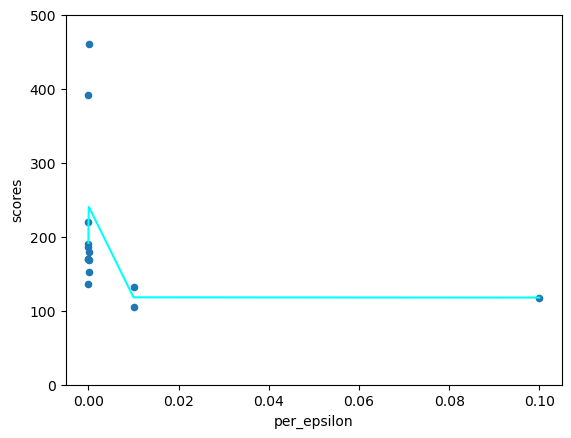

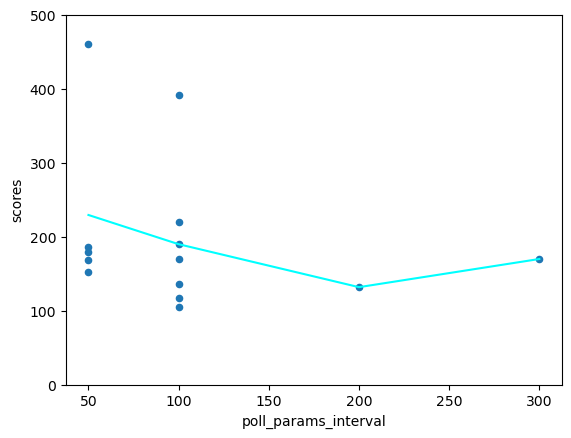

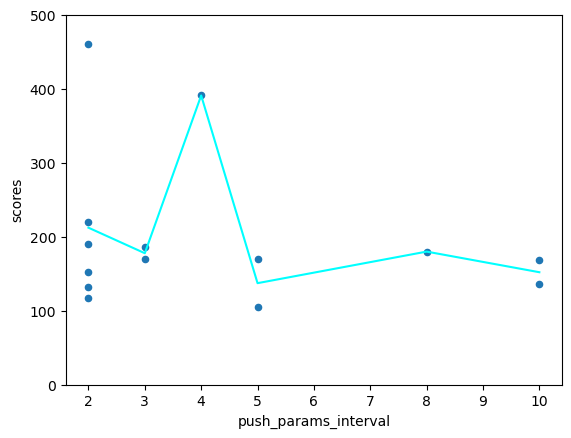

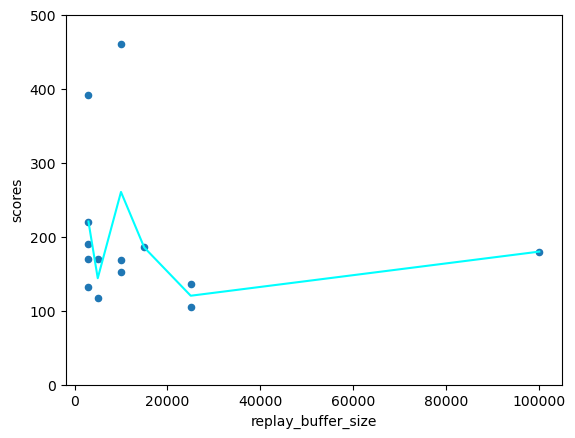

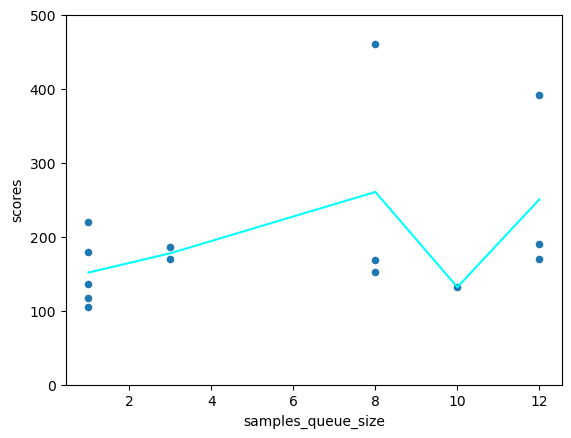

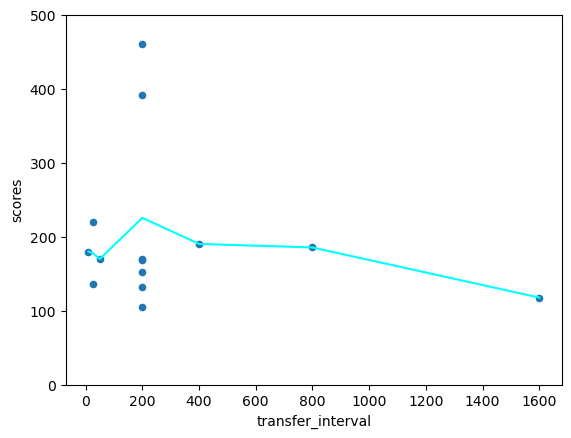

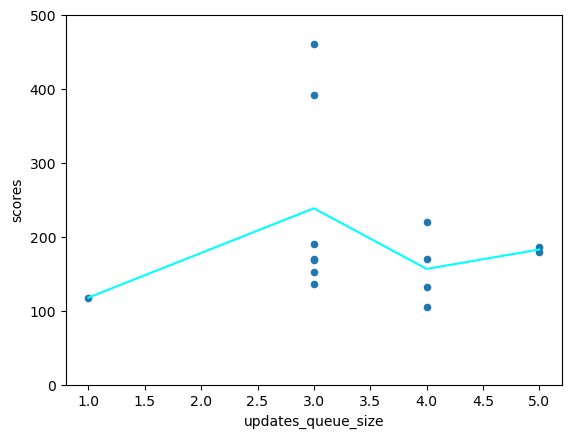

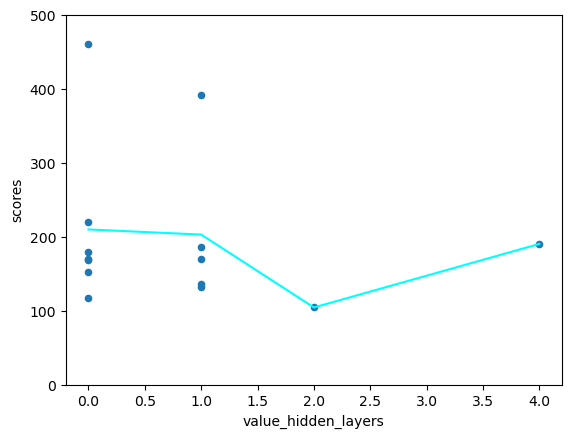

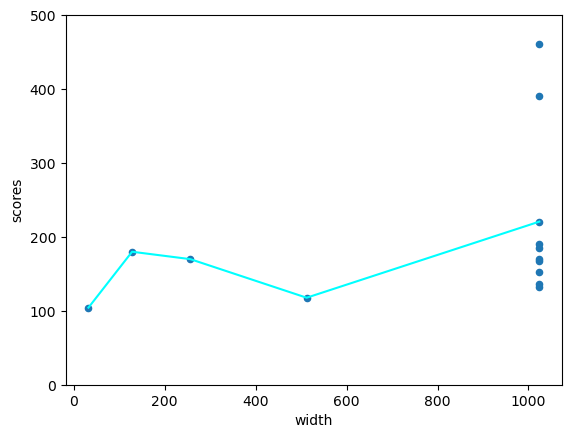

In [8]:
high_scores = df[df["scores"] > 100]
generate_graphs(high_scores, x_cols, "scores")